# Modelling, Simulation and Optimisation

## TABA

Student ID: x22240217, using 2170(seed value) for this study

### Generating Input Data

In [1]:
N_JOBS = 7
N_MACHINES = 4

In [2]:
import random

def generateData(seed=0):
    PROC = [ [ 0 for m in range(N_MACHINES) ] for j in range(N_JOBS) ]
    random.seed(seed)
    for j in range(N_JOBS):
        for m in range(N_MACHINES):
            PROC[j][m] = random.randint(1,9)
    return PROC

In [3]:
PROC = generateData(2170)

In [4]:
PROC

[[7, 5, 2, 8],
 [2, 5, 1, 5],
 [1, 9, 1, 9],
 [9, 7, 4, 5],
 [6, 9, 2, 2],
 [3, 1, 9, 3],
 [7, 4, 9, 9]]

### Integer Programming Solution

Given Code

In [5]:
import pulp

In [6]:
def val(x):
    return int(pulp.value(x))

In [7]:
prob = pulp.LpProblem("JobScheduling",pulp.LpMinimize)

`J[j]` defines the sequencing of jobs 'j' and is just a permutation of the job number:

In [8]:
JJ = pulp.LpVariable.dicts("J", (range(N_JOBS), range(N_JOBS)),
                           lowBound=0, upBound=1, cat='Integer')

In [9]:
def job(n):
    for j in range(N_JOBS):
        if val(JJ[n][j])==1:
            return j

In [10]:
def jobSequence():
    acc = []
    for j in range(N_JOBS):
        for jj in range(N_JOBS):
            if pulp.value(JJ[j][jj])==1:
                acc.append(jj)
    return acc

In [11]:
def proc(job, machine):
    global PROC
    return pulp.lpSum( [ PROC[j][machine] * JJ[j][job] for j in range(N_JOBS) ] ) 

`WAIT[j][m]` describes the wait time of job `j` before machine `m`

In [12]:
Wait = pulp.LpVariable.dicts("WAIT", (range(N_JOBS), range(N_MACHINES)),
                          lowBound=0, cat='Integer')

`IDLE[j][m]` describes the idle time of machine `m` before processing job `j` 

In [13]:
Idle = pulp.LpVariable.dicts("IDLE", (range(N_JOBS), range(N_MACHINES)),
                             lowBound=0, cat='Integer')

`START[j][m]` describes the start time of machine `m` processing job `j`

In [14]:
Start = pulp.LpVariable.dicts("START", (range(N_JOBS), range(N_MACHINES)),
                          lowBound=0, cat='Integer')

`STOP[j][m]` describes the stop time of machine `m` after processing job `j`

In [15]:
Stop = pulp.LpVariable.dicts("STOP", (range(N_JOBS), range(N_MACHINES)),
                          lowBound=0, cat='Integer')

In [16]:
prob += Stop[N_JOBS-1][N_MACHINES-1]

In [17]:
for j in range(N_JOBS):
    prob += pulp.lpSum( [ JJ[j][jj] for jj in range(N_JOBS) ] ) == 1
    prob += pulp.lpSum( [ JJ[jj][j] for jj in range(N_JOBS) ] ) == 1

In [18]:
for m in range(N_MACHINES):
    for j in range(N_JOBS):
        prob += pulp.lpSum( [ Idle[ji][m] + proc(ji, m) for ji in range(j) ] ) + Idle[j][m] == Start[j][m]

In [19]:
for m in range(N_MACHINES):
    for j in range(N_JOBS):
        prob += pulp.lpSum( [ Wait[j][mi] + proc(j, mi) for mi in range(m) ] ) + Wait[j][m] == Start[j][m]

In [20]:
for j in range(N_JOBS):
    for m in range(N_MACHINES):
        prob += Start[j][m] + proc(j,m) == Stop[j][m]

In [21]:
solvers = pulp.listSolvers(onlyAvailable=True) 
solver = pulp.getSolver(solvers[0], msg=0)
prob.solve(solver)

1

In [22]:
def schedule():
    row = ""
    row += '|---------|'
    for m in range(N_MACHINES):
        row += f"------------|" \
                f"------------|"
    row += '\n'
    row += '|         |'
    for m in range(N_MACHINES):
        row += f"            |" \
                f" Machine: {m:1d} |"
    row += '\n'
    for j in range(N_JOBS):
        row += '|---------|'
        for m in range(N_MACHINES):
            row += f"------------|" \
                   f"------------|"
        row += '\n'
        row += '|         |'
        for m in range(N_MACHINES):
            row += f"       {' ':4s} | " \
                   f"Idle: {val(Idle[j][m]):4d} |"
        row += '\n'
        row += '|---------|'
        for m in range(N_MACHINES):
            row += f"------------|" \
                   f"------------|"
        row += '\n'
        row += '|         |'
        for m in range(N_MACHINES):
            row += f"       {' ':4s} | " \
                   f"Start:{val(Start[j][m]):4d} |"  
        row += '\n' 
        row += f'| Job: {job(j):2d} |'
        for m in range(N_MACHINES):
            row += f" Wait: {val(Wait[j][m]):4d} | " \
                   f"Proc: {val(proc(j,m)):4d} |"
        row += '\n'
        row += '|         |'
        for m in range(N_MACHINES):
            row += f"       {' ':4s} | " \
                   f"Stop: {val(Stop[j][m]):4d} |"  
        row += '\n' 
    row += '|---------|'
    for m in range(N_MACHINES):
        row += f"------------|" \
                f"------------|"
    row += '\n'
    return row

The processing times per job and machine:

In [23]:
PROC

[[7, 5, 2, 8],
 [2, 5, 1, 5],
 [1, 9, 1, 9],
 [9, 7, 4, 5],
 [6, 9, 2, 2],
 [3, 1, 9, 3],
 [7, 4, 9, 9]]

The optimal job schedule:

In [24]:
print(jobSequence())

[1, 4, 0, 6, 5, 3, 2]


The processing time of the optimal job schedule:

In [25]:
int(pulp.value(prob.objective))

52

The optimal job schedule in detail:

In [26]:
print(schedule())

|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Machine: 0 |            | Machine: 1 |            | Machine: 2 |            | Machine: 3 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Idle:    0 |            | Idle:    1 |            | Idle:   10 |            | Idle:   11 |
|---------|------------|------------|------------|------------|------------|------------|------------|------------|
|         |            | Start:   0 |            | Start:   1 |            | Start:  10 |            | Start:  11 |
| Job:  1 | Wait:    0 | Proc:    1 | Wait:    0 | Proc:    9 | Wait:    0 | Proc:    1 | Wait:    0 | Proc:    9 |
|         |            | Stop:    1 |            | Stop:   10 |            | Stop:   11 |            | Stop:   20 |
|---------|------------|------------|------------|------------|---------

### Genetic Algorithm

In [27]:
# Below function is essential for evaluating the fitness of candidate schedules for determining the optimal Schedule
def calculate_makespan(schedule, proc):
    end_times = np.zeros((N_JOBS, N_MACHINES))
    for idx, job in enumerate(schedule):
        for m in range(N_MACHINES):
            if idx == 0 and m == 0:
                end_times[job][m] = proc[job][m]
            elif idx == 0:
                end_times[job][m] = end_times[job][m-1] + proc[job][m]
            elif m == 0:
                end_times[job][m] = end_times[schedule[idx-1]][m] + proc[job][m]
            else:
                end_times[job][m] = max(end_times[job][m-1], end_times[schedule[idx-1]][m]) + proc[job][m]
    return end_times[schedule[-1]][-1]

# Calculate the fitness value of a given schedule based on the reciprocal of its makespan
def fitness(schedule, proc):
    return 1 / calculate_makespan(schedule, PROC)

# Initialize a population of schedules by randomly shuffling job sequences
def initialize_population(size):
    return [random.sample(range(N_JOBS), N_JOBS) for _ in range(size)]

# Select parents for crossover using tournament selection with a specified tournament size
def select_parents(population, proc):
    return random.sample(population, 2)

# Add two children to the population and keep the population size constant by selecting the top individuals based on fitness
def addChildren(population, X, Y):
    n = len(population)
    population = add(population, X)
    population = add(population, Y)
    
    if len(population) > n:
        return sorted(population, key=lambda p: fitness(p), reverse=True)[0:n]
    else:
        return population

# Perform crossover between two parents to generate a child
def crossover(parent1, parent2):
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None]*size
    child[start:end] = parent1[start:end]
    fill = [item for item in parent2 if item not in child[start:end]]
    child = fill[:start] + child[start:end] + fill[start:]
    return child

# Mutate the given schedule with 0.1 mutation rate
def mutate(schedule, mutation_rate=0.1):
    schedule = schedule[:]
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(schedule)), 2)
        schedule[i], schedule[j] = schedule[j], schedule[i]
    return schedule

In [29]:
# Genetic algorithm for job scheduling
import numpy as np
def genetic_algorithm(generations=128, pop_size=128, mutation_rate=0.1, logging=True):
    proc = generateData(seed=2170)
    population = initialize_population(pop_size)

    for generation in range(generations):
        new_population = []
        for _ in range(pop_size // 2):
            parent1, parent2 = select_parents(population, proc)
            child1 = crossover(parent1, parent2)
            child1 = mutate(child1, mutation_rate)
            child2 = crossover(parent2, parent1)
            child2 = mutate(child2, mutation_rate)
            new_population.extend([child1, child2])
        
        # Evaluate new population's fitness and sort
        population = sorted(new_population, key=lambda indiv: fitness(indiv, proc), reverse=True)[:pop_size]

        # Evaluate the best schedule in the current population
        best_in_pop = max(population, key=lambda indiv: fitness(indiv, proc))
        best_in_pop_fitness = fitness(best_in_pop, proc)
        best_in_pop_makespan = calculate_makespan(best_in_pop, proc)

        # Iterative generations
        if logging:
            print(f"Generation {generation + 1}:")
            print("  Best Schedule:", best_in_pop)
            print("  Best Fitness:", best_in_pop_fitness)
            print("  Best Makespan:", best_in_pop_makespan)
            print()

    # Final best schedule and evaluation
    best_schedule = max(population, key=lambda indiv: fitness(indiv, proc))
    best_fitness = fitness(best_schedule, proc)
    best_makespan = calculate_makespan(best_schedule, proc)
    return best_schedule, best_makespan, best_fitness

# Example of calling the genetic algorithm with logging enabled
best_schedule, best_makespan, best_fitness = genetic_algorithm(logging=True)
print("Final Best Schedule:", best_schedule)
print("Final Best Makespan:", best_makespan)
print("Final Best Fitness:", best_fitness)


Generation 1:
  Best Schedule: [2, 5, 1, 3, 0, 6, 4]
  Best Fitness: 0.018867924528301886
  Best Makespan: 53.0

Generation 2:
  Best Schedule: [2, 0, 5, 1, 6, 3, 4]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 3:
  Best Schedule: [2, 0, 6, 1, 5, 3, 4]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 4:
  Best Schedule: [2, 1, 5, 0, 6, 3, 4]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 5:
  Best Schedule: [2, 5, 1, 0, 6, 3, 4]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 6:
  Best Schedule: [2, 0, 6, 1, 5, 3, 4]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 7:
  Best Schedule: [2, 1, 5, 0, 6, 4, 3]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 8:
  Best Schedule: [2, 5, 1, 0, 6, 4, 3]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 9:
  Best Schedule: [2, 5, 0, 6, 4, 1, 3]
  Best Fitness: 0.018518518518518517
  Best

Generation 83:
  Best Schedule: [2, 0, 6, 5, 1, 4, 3]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 84:
  Best Schedule: [2, 1, 0, 6, 3, 5, 4]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 85:
  Best Schedule: [2, 0, 6, 5, 1, 4, 3]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 86:
  Best Schedule: [2, 0, 6, 5, 1, 4, 3]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 87:
  Best Schedule: [2, 0, 1, 5, 3, 6, 4]
  Best Fitness: 0.018518518518518517
  Best Makespan: 54.0

Generation 88:
  Best Schedule: [2, 1, 5, 0, 6, 3, 4]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 89:
  Best Schedule: [2, 5, 3, 1, 0, 6, 4]
  Best Fitness: 0.018518518518518517
  Best Makespan: 54.0

Generation 90:
  Best Schedule: [2, 1, 5, 0, 6, 4, 3]
  Best Fitness: 0.019230769230769232
  Best Makespan: 52.0

Generation 91:
  Best Schedule: [2, 0, 6, 1, 5, 4, 3]
  Best Fitness: 0.0192307692307692

In [30]:
# Calculate makespan and generate timelines for job start and end times
import numpy as np

def calculate_makespan_and_timeline(schedule, proc):
    end_times = np.zeros((N_JOBS, N_MACHINES))
    start_times = np.zeros((N_JOBS, N_MACHINES))
    for idx, job in enumerate(schedule):
        for m in range(N_MACHINES):
            if idx == 0 and m == 0:
                start_times[job][m] = 0
                end_times[job][m] = proc[job][m]
            elif idx == 0:
                start_times[job][m] = end_times[job][m-1]
                end_times[job][m] = start_times[job][m] + proc[job][m]
            elif m == 0:
                start_times[job][m] = end_times[schedule[idx-1]][m]
                end_times[job][m] = start_times[job][m] + proc[job][m]
            else:
                start_times[job][m] = max(end_times[job][m-1], end_times[schedule[idx-1]][m])
                end_times[job][m] = start_times[job][m] + proc[job][m]
    return end_times[schedule[-1]][-1], start_times, end_times

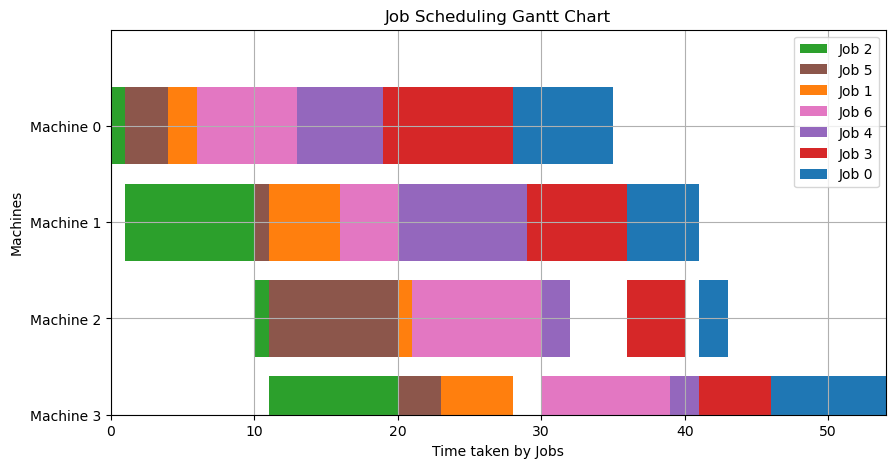

In [31]:
# To plot Gantt chart for the observations
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_gantt_chart(schedule, start_times, end_times):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = list(mcolors.TABLEAU_COLORS.keys())
    # Create machine labels in reverse order
    machines = ['Machine {}'.format(N_MACHINES - 1 - i) for i in range(N_MACHINES)]

    for idx, job in enumerate(schedule):
        for m in range(N_MACHINES):
            start = start_times[job][m]
            duration = end_times[job][m] - start
            # Plot in reverse order by subtracting m from N_MACHINES - 1
            machine_position = N_MACHINES - 1 - m
            ax.broken_barh([(start, duration)], (machine_position - 0.4, 0.8), facecolors=colors[job % len(colors)], label=f'Job {job}' if m == 0 else "")

    ax.set_ylim(0, N_MACHINES)
    ax.set_xlim(0, np.max(end_times))
    ax.set_xlabel('Time taken by Jobs')
    ax.set_ylabel('Machines')
    ax.set_yticks(range(N_MACHINES))
    ax.set_yticklabels(machines)
    ax.set_title('Job Scheduling Gantt Chart')
    # Ensure that legends do not repeat
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show()

# Calculate makespan and generate timelines for job start and end times
best_makespan, start_times, end_times = calculate_makespan_and_timeline(best_schedule, PROC)
plot_gantt_chart(best_schedule, start_times, end_times)


### Ant Colony Optmization

In [32]:
import numpy as np
import random

# Initial specific parameters
num_ants = N_JOBS  # One ant per job
num_iterations = 100
evaporation_rate = 0.5
pheromone_deposit = 1.0
initial_pheromone = 1.0 / N_JOBS

# To Generate processing times
processing_times = generateData(2170)

# To Initialize pheromone levels
pheromones = np.ones((N_JOBS, N_JOBS)) * initial_pheromone

In [33]:
# ACO Algorithm
def calculate_makespan_and_timeline(schedule):
    job_start_times = np.zeros((N_MACHINES, N_JOBS))
    job_end_times = np.zeros((N_MACHINES, N_JOBS))
    for idx, job in enumerate(schedule):
        for machine in range(N_MACHINES):
            if machine == 0:
                job_start_times[machine][idx] = job_end_times[machine][idx-1] if idx > 0 else 0
            else:
                job_start_times[machine][idx] = max(job_end_times[machine-1][idx], job_end_times[machine][idx-1])
            job_end_times[machine][idx] = job_start_times[machine][idx] + processing_times[job][machine]
    return job_end_times[-1][-1], job_start_times, job_end_times

def select_next_job(current_job, taboo_list):
    probabilities = pheromones[current_job] * np.array([1 if i not in taboo_list else 0 for i in range(N_JOBS)])
    if probabilities.sum() == 0:
        return random.choice([i for i in range(N_JOBS) if i not in taboo_list])
    probabilities /= probabilities.sum()
    return np.random.choice(N_JOBS, p=probabilities)

# Ant Colony Optimization
best_schedule = None
best_makespan = float('inf')
best_start_times = None
best_end_times = None

for iteration in range(num_iterations):
    for ant in range(num_ants):
        schedule = []
        current_job = random.randint(0, N_JOBS - 1)
        schedule.append(current_job)
        taboo_list = set(schedule)

        while len(taboo_list) < N_JOBS:
            next_job = select_next_job(current_job, taboo_list)
            schedule.append(next_job)
            taboo_list.add(next_job)
            current_job = next_job

        makespan, start_times, end_times = calculate_makespan_and_timeline(schedule)
        if makespan < best_makespan:
            best_makespan = makespan
            best_schedule = schedule
            best_start_times = start_times
            best_end_times = end_times

    # Update pheromones
    pheromones *= (1 - evaporation_rate)  # Evaporate pheromones
    for idx in range(N_JOBS-1):
        pheromones[best_schedule[idx]][best_schedule[idx+1]] += pheromone_deposit

    print(f"Iteration {iteration}: Best Makespan = {best_makespan}, Job Sequence = {best_schedule}")

# Output the best solution found
print("Best job sequence:", best_schedule)
print("Best makespan:", best_makespan)



Iteration 0: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 1: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 2: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 3: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 4: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 5: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 6: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 7: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 8: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 9: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 10: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 11: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 12: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 4, 0, 5, 1]
Iteration 13: Best Makespan = 57.0, Job Sequence = [2, 3, 6, 

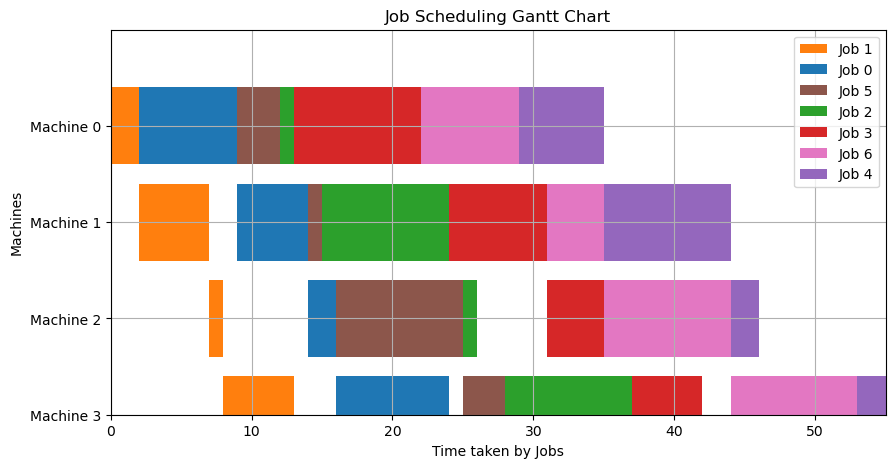

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_gantt_chart(schedule, start_times, end_times):
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = list(mcolors.TABLEAU_COLORS.keys())[:N_JOBS]
    machines = ['Machine {}'.format(N_MACHINES - 1 - i) for i in range(N_MACHINES)]

    for idx, job in enumerate(schedule):
        for m in range(N_MACHINES):
            start = start_times[m][idx]
            duration = end_times[m][idx] - start
            machine_position = N_MACHINES - 1 - m
            ax.broken_barh([(start, duration)], (machine_position - 0.4, 0.8), facecolors=colors[job % len(colors)], label=f'Job {job}' if m == 0 else "")

    ax.set_ylim(0, N_MACHINES)
    ax.set_xlim(0, np.max(end_times))
    ax.set_xlabel('Time taken by Jobs')
    ax.set_ylabel('Machines')
    ax.set_yticks(range(N_MACHINES))
    ax.set_yticklabels(machines)
    ax.set_title('Job Scheduling Gantt Chart')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.grid(True)
    plt.show()

# Plot Gantt chart
plot_gantt_chart(best_schedule, best_start_times, best_end_times)
